In [3]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split

# # Load the data
# data = pd.read_csv('/content/Kosi Rainfall + metrics daily (2014-2023).csv')

# # Rename columns to match the expected names
# data.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day'}, inplace=True)

# # Create a datetime index
# data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
# data.set_index('date', inplace=True)

# # Drop the year, month, day, LAT, and LON columns
# data.drop(columns=['year', 'month', 'day', 'LAT', 'LON'], inplace=True)

# # Handle missing values if any
# data = data.fillna(method='ffill').fillna(method='bfill')

# # Normalize the data
# scaler = MinMaxScaler()
# data_normalized = scaler.fit_transform(data)

# # Create sequences
# def create_sequences(data, seq_length):
#     xs, ys = [], []
#     for i in range(len(data) - seq_length):
#         x = data[i:i+seq_length]
#         y = data[i+seq_length]
#         xs.append(x)
#         ys.append(y)
#     return np.array(xs), np.array(ys)

# seq_length = 30  # Example sequence length
# X, y = create_sequences(data_normalized, seq_length)

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)













import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the data
data = pd.read_csv('/content/Kosi Rainfall + metrics daily (2014-2023).csv')

# Rename columns to match the expected names
data.rename(columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day'}, inplace=True)

# Create a datetime index
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data.set_index('date', inplace=True)

# Drop the year, month, day, LAT, and LON columns
data.drop(columns=['year', 'month', 'day', 'LAT', 'LON'], inplace=True)

# Handle missing values if any
data = data.fillna(method='ffill').fillna(method='bfill')

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# Feature Engineering: Adding lag features
for lag in range(1, 4):
    data[f'PRECTOTCORR_lag{lag}'] = data['PRECTOTCORR'].shift(lag)
    data[f'WS10M_lag{lag}'] = data['WS10M'].shift(lag)

data = data.dropna()

# Normalize the data again after adding lag features
data_normalized = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # Example sequence length
X, y = create_sequences(data_normalized, seq_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [4]:
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add, Reshape, GlobalAveragePooling1D

# # CNN part
# def build_cnn(input_shape):
#     inputs = Input(shape=input_shape)
#     x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
#     x = MaxPooling1D(pool_size=2)(x)
#     x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
#     x = MaxPooling1D(pool_size=2)(x)
#     model = Model(inputs, x)
#     return model

# # Transformer part
# def build_transformer(input_shape):
#     inputs = Input(shape=input_shape)
#     x = LayerNormalization(epsilon=1e-6)(inputs)
#     x = MultiHeadAttention(num_heads=4, key_dim=input_shape[-1])(x, x)
#     x = Dropout(0.1)(x)
#     x = Add()([inputs, x])
#     x = LayerNormalization(epsilon=1e-6)(x)
#     x = Dense(units=128, activation='relu')(x)
#     model = Model(inputs, x)
#     return model

# input_shape = (seq_length, data_normalized.shape[1])
# cnn_model = build_cnn(input_shape)

# # The output of the CNN model should be reshaped to match the Transformer input requirements
# cnn_output_shape = cnn_model.output_shape[1:]  # (sequence_length, features)
# cnn_output = Reshape((cnn_output_shape[0], -1))(cnn_model.output)

# transformer_model = build_transformer(cnn_output.shape[1:])

# # Combine CNN and Transformer
# combined_input = Input(shape=input_shape)
# cnn_output = cnn_model(combined_input)
# cnn_output = Reshape((cnn_output_shape[0], -1))(cnn_output)
# transformer_output = transformer_model(cnn_output)
# transformer_output = GlobalAveragePooling1D()(transformer_output)  # Pooling to get a fixed shape
# output = Dense(data_normalized.shape[1])(transformer_output)

# model = Model(combined_input, output)
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# model.summary()











import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, LayerNormalization, MultiHeadAttention, Dropout, Add, Reshape, Flatten, Bidirectional, LSTM

# CNN part
def build_cnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    model = Model(inputs, x)
    return model

# Transformer part
def build_transformer(input_shape):
    inputs = Input(shape=input_shape)
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=4, key_dim=input_shape[-1])(x, x)
    x = Dropout(0.1)(x)
    x = Add()([inputs, x])
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(units=128, activation='relu')(x)
    model = Model(inputs, x)
    return model

input_shape = (seq_length, data_normalized.shape[1])
cnn_model = build_cnn(input_shape)

# The output of the CNN model should be reshaped to match the Transformer input requirements
cnn_output_shape = cnn_model.output_shape[1:]  # (features,)
cnn_output = Reshape((1, cnn_output_shape[0]))(cnn_model.output)

transformer_model = build_transformer(cnn_output.shape[1:])

# Combine CNN and Transformer
combined_input = Input(shape=input_shape)
cnn_output = cnn_model(combined_input)
cnn_output = Reshape((1, cnn_output_shape[0]))(cnn_output)
transformer_output = transformer_model(cnn_output)
flattened_output = Flatten()(transformer_output)
output = Dense(data_normalized.shape[1])(flattened_output)

model = Model(combined_input, output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 12)]          0         
                                                                 
 model (Functional)          (None, 128)               125504    
                                                                 
 reshape_1 (Reshape)         (None, 1, 128)            0         
                                                                 
 model_1 (Functional)        (None, 1, 128)            280832    
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 12)                1548      
                                                                 
Total params: 407884 (1.56 MB)
Trainable params: 407884 (1.

In [9]:
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)





history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)


Epoch 1/50
46/46 [==============================] - 2s 36ms/step - loss: 0.0043 - mae: 0.0426 - val_loss: 0.0055 - val_mae: 0.0466
Epoch 2/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0044 - mae: 0.0428 - val_loss: 0.0049 - val_mae: 0.0420
Epoch 3/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0041 - mae: 0.0412 - val_loss: 0.0050 - val_mae: 0.0420
Epoch 4/50
46/46 [==============================] - 2s 33ms/step - loss: 0.0041 - mae: 0.0409 - val_loss: 0.0049 - val_mae: 0.0421
Epoch 5/50
46/46 [==============================] - 2s 33ms/step - loss: 0.0041 - mae: 0.0413 - val_loss: 0.0049 - val_mae: 0.0426
Epoch 6/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0040 - mae: 0.0409 - val_loss: 0.0050 - val_mae: 0.0438
Epoch 7/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0040 - mae: 0.0405 - val_loss: 0.0051 - val_mae: 0.0437
Epoch 8/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0040 - m

In [10]:
model.save('cnn_transformer_precipitation_csv.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y_pred = model.predict(X_test)
# y_test_inverse = scaler.inverse_transform(y_test)
# y_pred_inverse = scaler.inverse_transform(y_pred)

# mse = mean_squared_error(y_test_inverse, y_pred_inverse)
# mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test_inverse, y_pred_inverse)

# print(f'MSE: {mse}')
# print(f'MAE: {mae}')
# print(f'RMSE: {rmse}')
# print(f'R-squared: {r2}')

# # Calculate metrics for each parameter separately
# metrics = {
#     'MSE': mean_squared_error,
#     'MAE': mean_absolute_error,
#     'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
#     'R-squared': r2_score
# }

# for i, column in enumerate(data.columns):
#     print(f'\nMetrics for {column}:')
#     for metric_name, metric_func in metrics.items():
#         value = metric_func(y_test_inverse[:, i], y_pred_inverse[:, i])
#         print(f'{metric_name}: {value}')












from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inverse, y_pred_inverse)

print("MODEL:")
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

# Calculate metrics for each parameter separately
metrics = {
    'MSE': mean_squared_error,
    'MAE': mean_absolute_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'R-squared': r2_score
}

for i, column in enumerate(data.columns):
    print(f'\n{column}:')
    for metric_name, metric_func in metrics.items():
        value = metric_func(y_test_inverse[:, i], y_pred_inverse[:, i])
        print(f'{metric_name}: {value}')


23/23 [==============================] - 0s 7ms/step
MODEL:
MSE: 1073.5807800435346
MAE: 3.8120719616245684
RMSE: 32.76554257209141
R-squared: 0.6339236658599781

PRECTOTCORR:
MSE: 43.71885576560373
MAE: 3.0410742221050384
RMSE: 6.612023575699328
R-squared: 0.22251483344735268

WS10M:
MSE: 1.1200362448083503
MAE: 0.7936332626632565
RMSE: 1.058317648349658
R-squared: 0.2736895343175023

RH2M:
MSE: 46.45783451581631
MAE: 5.106193016354221
RMSE: 6.81599842398869
R-squared: 0.9021024797011806

QV2M:
MSE: 2.2832875828682186
MAE: 1.092109061538844
RMSE: 1.5110551223791338
R-squared: 0.943081040916199

T2M_RANGE:
MSE: 3.585600875804054
MAE: 1.4339086484382166
RMSE: 1.8935682918247374
R-squared: 0.8149344931259676

ALLSKY_SFC_UV_INDEX:
MSE: 12745.077426106767
MAE: 26.878140234805603
RMSE: 112.8940982784608
R-squared: -0.03737169376235694

PRECTOTCORR_lag1:
MSE: 15.977649112944595
MAE: 2.250130184295583
RMSE: 3.997205162728653
R-squared: 0.6322837284159388

WS10M_lag1:
MSE: 0.36087892013708583


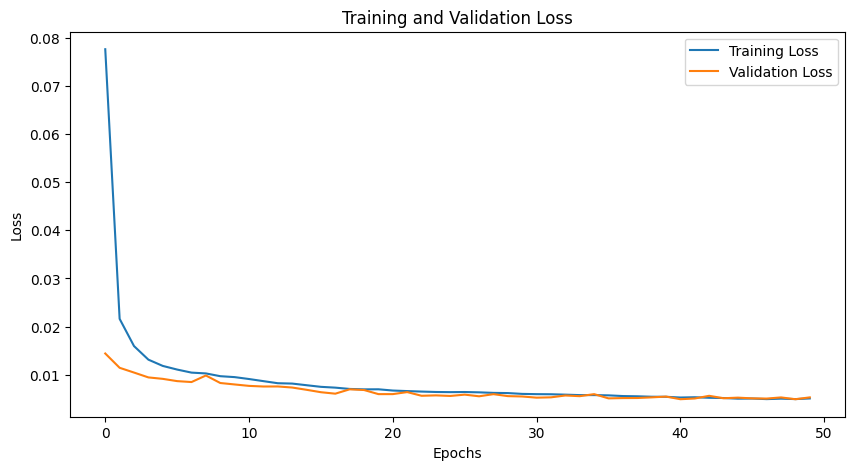

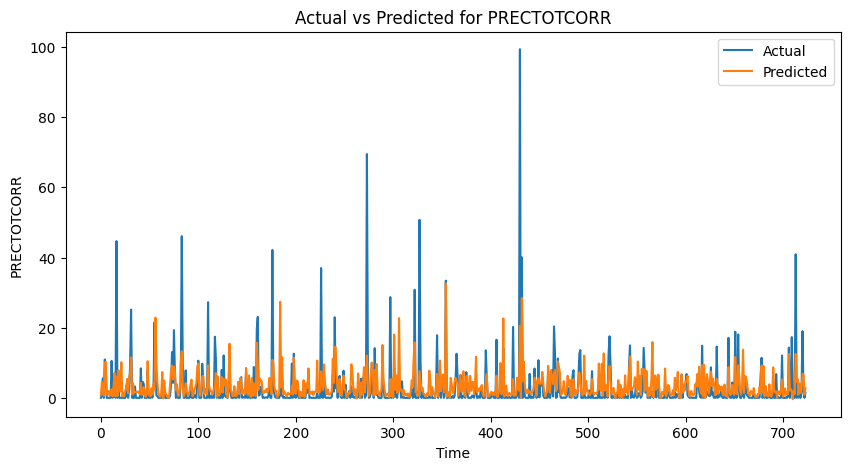

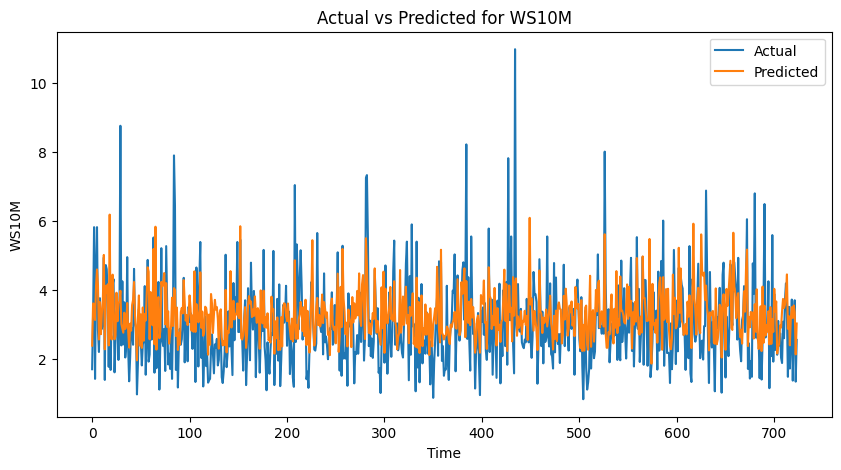

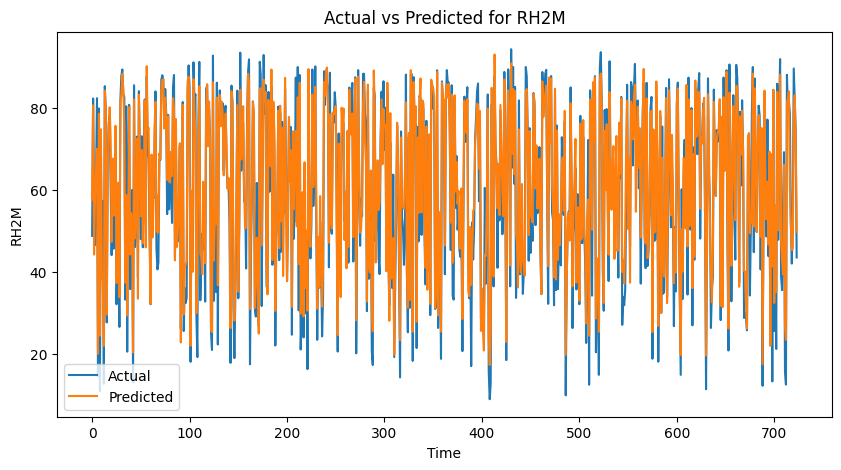

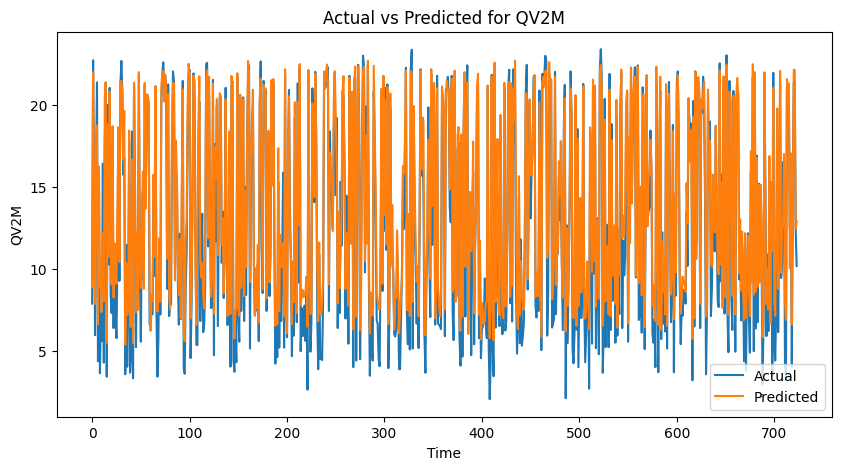

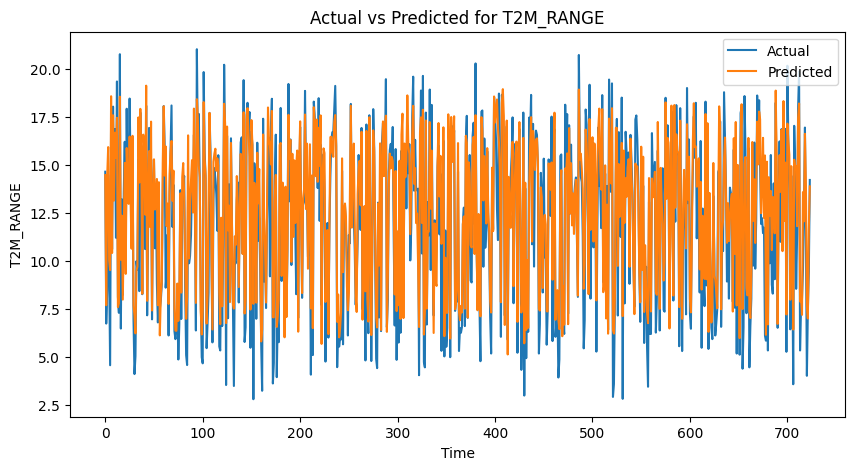

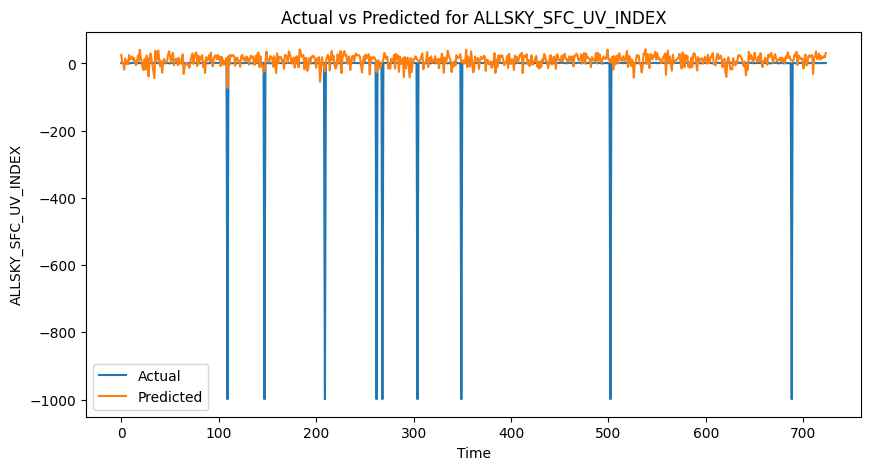

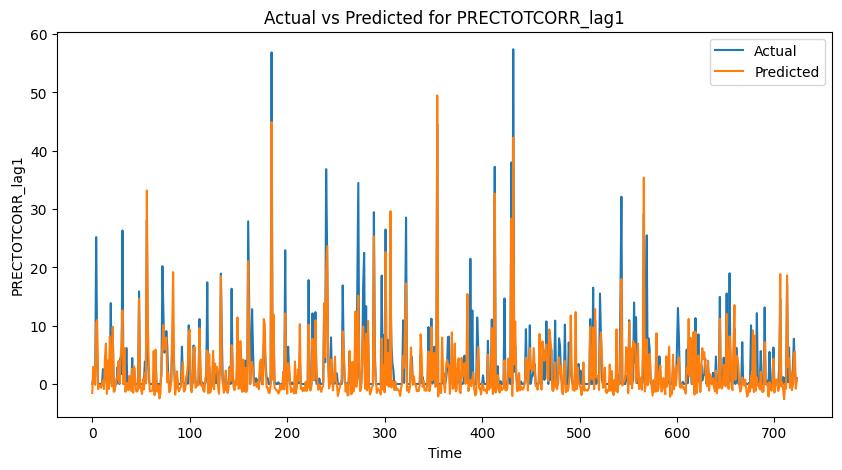

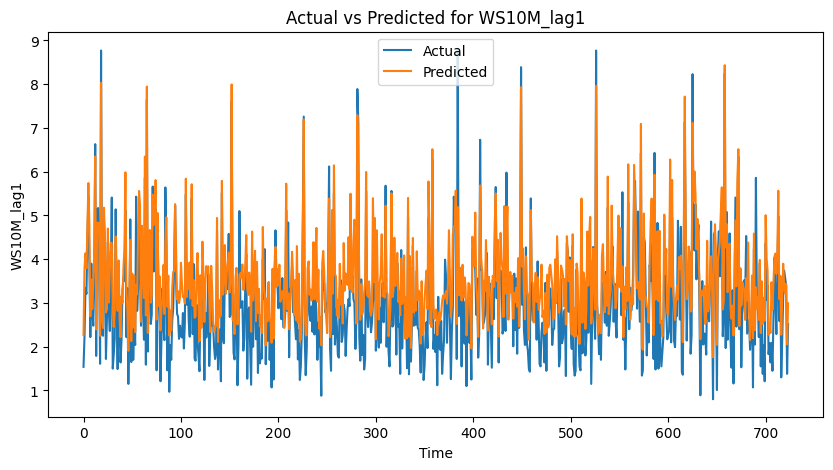

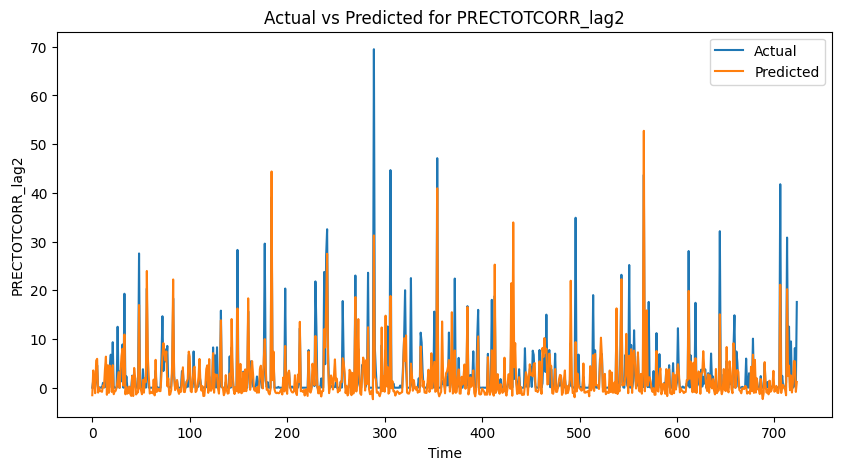

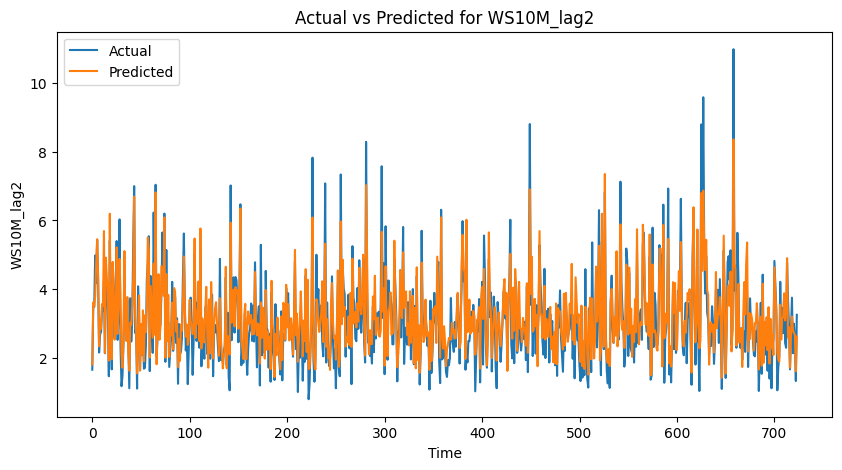

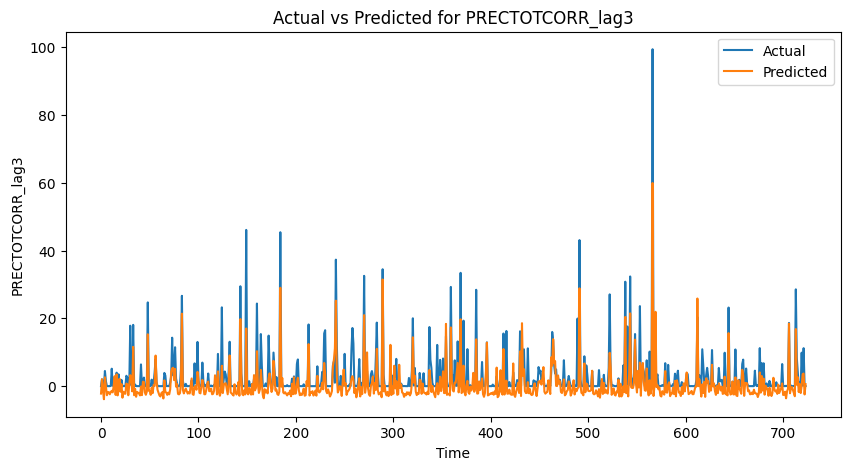

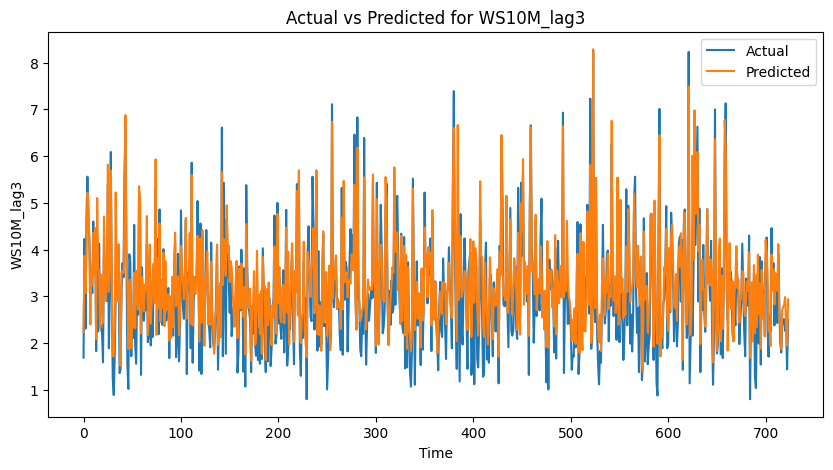

In [ ]:
# import matplotlib.pyplot as plt

# # Plot training and validation loss
# plt.figure(figsize=(14, 5))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot predictions vs actual values for each parameter
# for i, column in enumerate(data.columns):
#     plt.figure(figsize=(14, 5))
#     plt.plot(y_test_inverse[:, i], label='Actual')
#     plt.plot(y_pred_inverse[:, i], label='Predicted')
#     plt.title(f'Actual vs Predicted for {column}')
#     plt.xlabel('Time')
#     plt.ylabel(column)
#     plt.legend()
#     plt.show()











import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values for each parameter
for i, column in enumerate(data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_inverse[:, i], label='Actual')
    plt.plot(y_pred_inverse[:, i], label='Predicted')
    plt.title(f'Actual vs Predicted for {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.show()
